In [1]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [2]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [3]:
%run DATA_users.py
%run DATA_parameters.py

# Step 1

- Just one class of users is considered
- n_daily_clicks and cum_daily_costs are known
- convertion_rate is unknown

### Environment

In [4]:
class Environment:
    def __init__(self, prices, margin_param, n_daily_clicks, cum_daily_costs, userclass):
        self.userclass = userclass #obs: I think python takes userclass by reference
        
        self.pricing_environment = PricingEnvironment(prices, margin_param, userclass)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)#to be sure that it is an integer and greater than 0
        self.cum_daily_costs = cum_daily_costs

    def round(self, pulled_arm):
        converted_clicks, reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)
        return converted_clicks, reward

### Learners
Obs:
- here the arms are for the prices
- since the bidding part is fixed, the arm that maximizes the reward is the arm that maximizes the convertion_rate*price

In [6]:
class Custom_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = UCB1_Learner(n_arms)


    def pull_arm(self):
        ub_alphas = self.conversion_rate_learner.empirical_means + self.conversion_rate_learner.confidence
        ub_alphasxprices = ub_alphas * self.arms_prices

        idx_arm = np.random.choice(np.where(ub_alphasxprices == ub_alphasxprices.max())[0])
        return idx_arm


    def update(self, pulled_arm, converted_clicks, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        alpha = converted_clicks / self.n_daily_clicks #conversion rate
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [32]:
class Custom_TS_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = Binomial_TS_Learner(n_arms)

    def pull_arm(self):
        sampled_alphas = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        idx_arm = np.argmax(sampled_alphas * self.arms_prices)
        return idx_arm


    def update(self, pulled_arm, converted_clicks, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        self.conversion_rate_learner.update(pulled_arm, converted_clicks, self.n_daily_clicks)

## Example

In [51]:
# Training parameters
T = 365
n_experiments = 1000

In [52]:
# Simulation parameters
BID_STEP1 = BIDS[55]

n_daily_clicks = int(C1.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1.cum_daily_costs_function(BID_STEP1)

opt_arm = np.argmax(C1.conversion_rate_function(PRICES) * PRICES) #optimal value of convertion rate between the arms
opt_price = PRICES[opt_arm]

opt = n_daily_clicks * C1.conversion_rate_function(opt_price) * (opt_price - MARGIN_PARAM) - cum_daily_costs

print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price: ", opt_price)
print("convertion rate on the optimal price: ", C1.conversion_rate_function(opt_arm))
print("optimal reward: ", opt)

n_daily_clicks:  100
cum_daily_costs:  12.0

optimal price:  50
convertion rate on the optimal price:  10.964244564633127
optimal reward:  3588.0


### UCB

In [53]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1)
    ucb_learner = Custom_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        converted_clicks, reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, converted_clicks, reward)
        
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm])

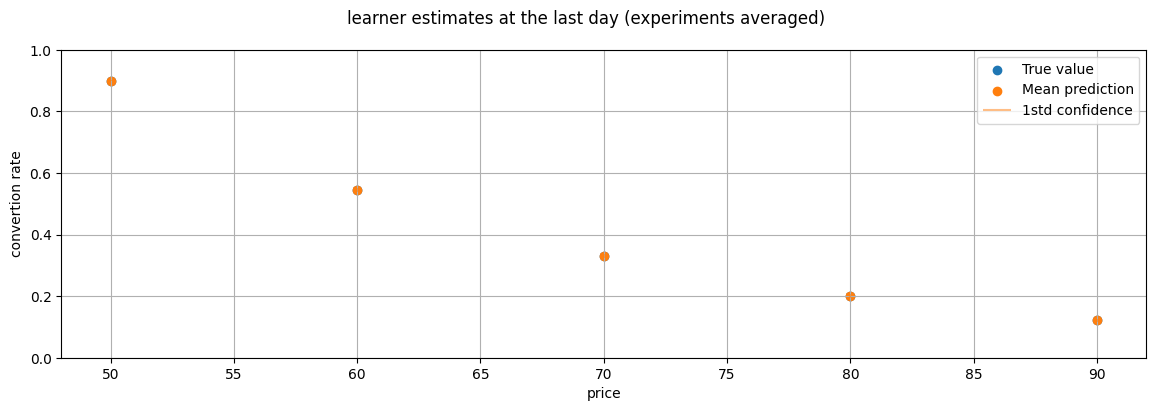

In [54]:
# Plot of the conversion rate

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.ylim((0,1))
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

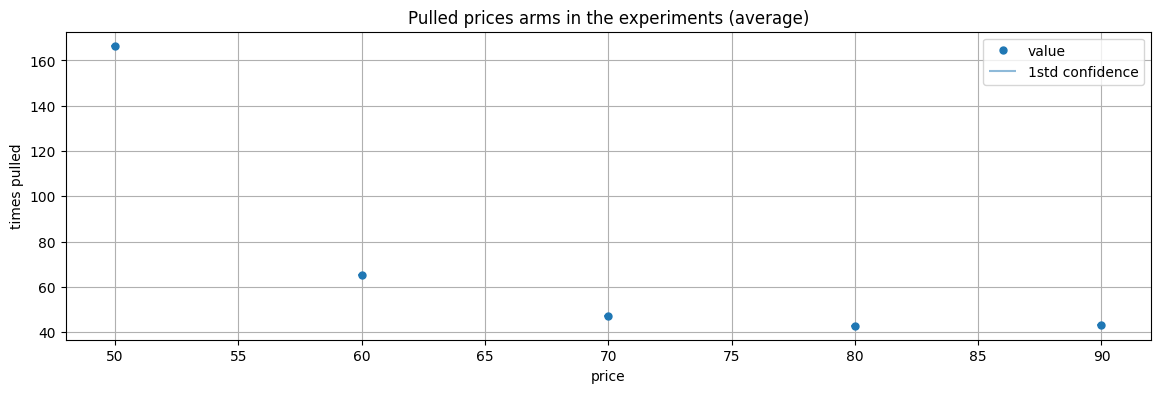

In [75]:
# plots pulled arms
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)
zz_std = np.std(ucb_pulled_arms_counter_per_experiment, axis = 0)


fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, zz, '.',  markersize = 10, color = "C0", label = "value")

plt.vlines(PRICES, zz - ucb_conversion_rate_std, zz +  ucb_conversion_rate_std,
           colors='C0', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, zz - ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.scatter(PRICES, zz + ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.legend()
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')


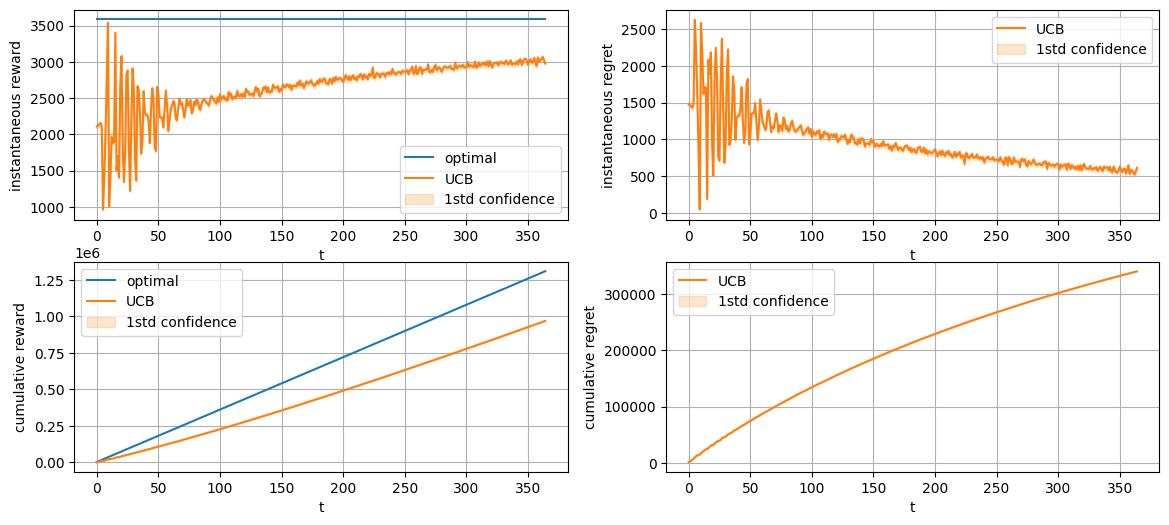

In [79]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()


plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Thompson Sampling

In [33]:
## TS learner

ts_rewards_per_experiment = []

ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1)
    ts_learner = Custom_TS_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        converted_clicks, reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, converted_clicks, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1]))
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ts_learner.rewards_per_arm])

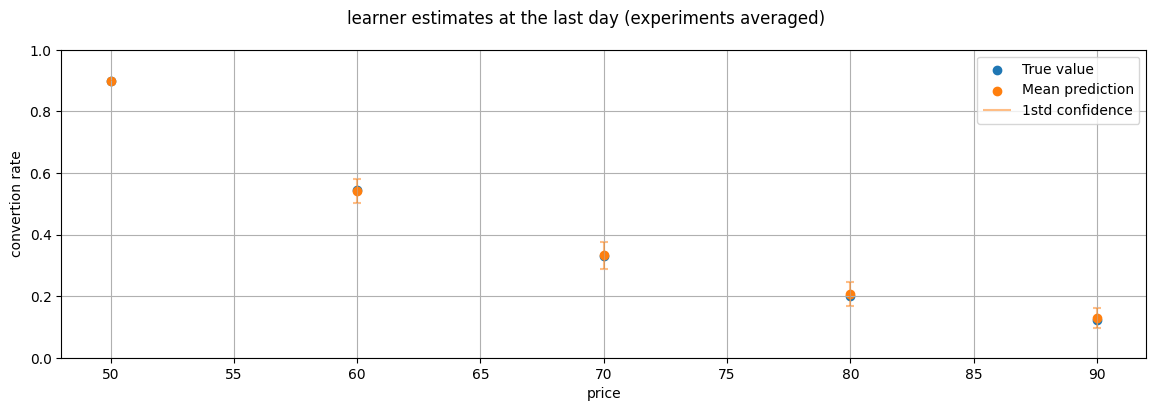

In [34]:
# Plot of the conversion rate

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0)
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)



plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()


plt.ylim((0,1))
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

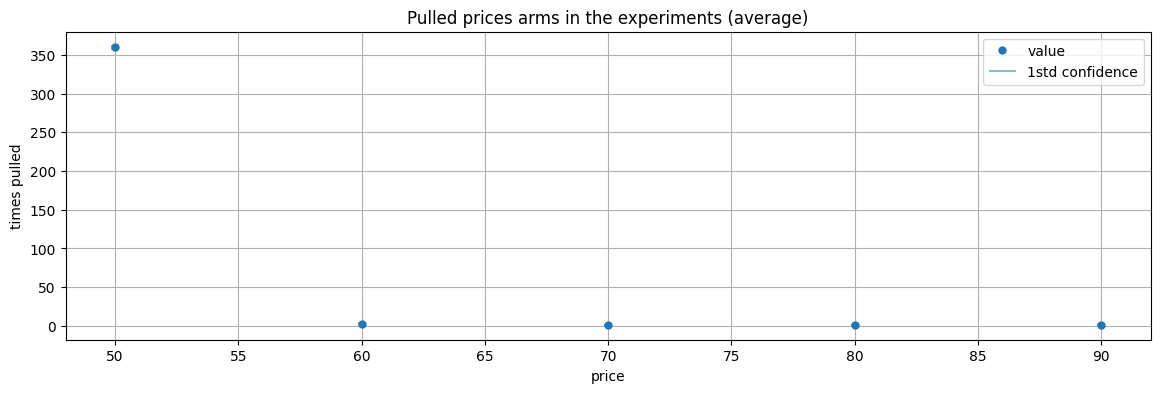

In [80]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)
zz_std = np.std(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, zz, '.',  markersize = 10, color = "C0", label = "value")

plt.vlines(PRICES, zz - zz_std, zz +  zz_std,
           colors='C0', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, zz - zz_std, color='C0', alpha=0.5, marker='_')
plt.scatter(PRICES, zz + zz_std, color='C0', alpha=0.5, marker='_')
plt.legend()
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')

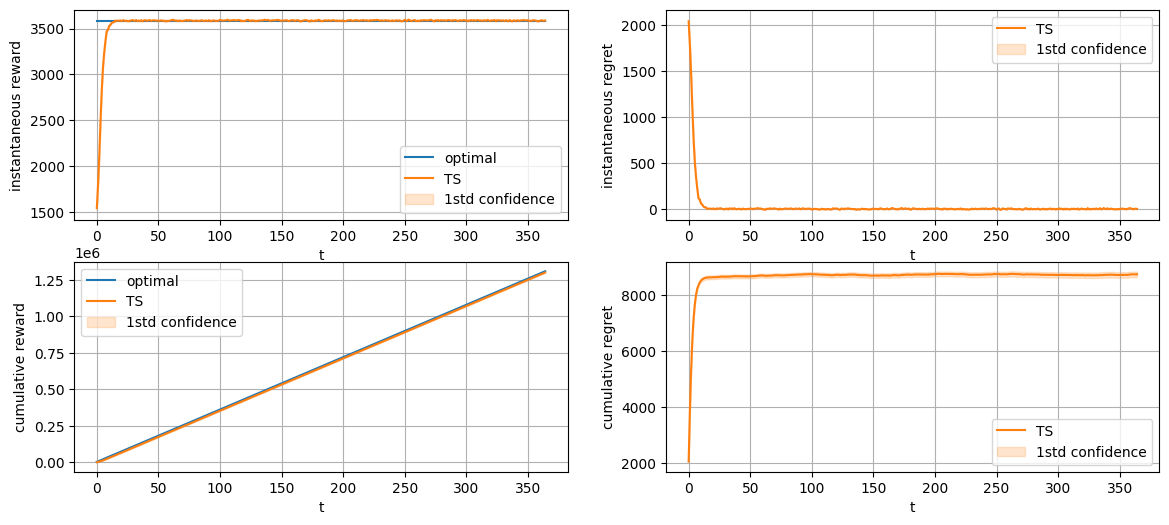

In [81]:
std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

#Starting Plots
plt.figure(figsize = (14,6))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Instantaneous regret plot
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat - std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Cumulative regret plot
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Plots both methods

In [82]:
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

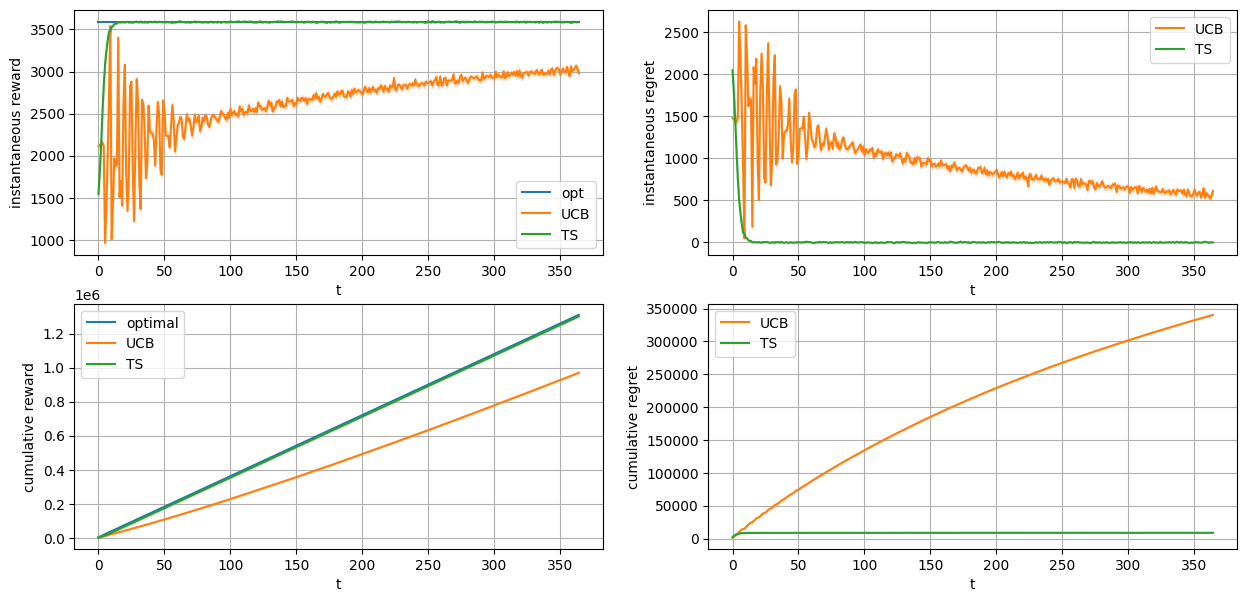

In [83]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

# Step 2

hp:
- just one class of users
- alpha is known
- n and c are unknown

OBS:I'm assuming that we can see both the number of clicks and the costs of the advertising (other than the reward)

About the learner: we are using 2 GP-Bandit learners one for the number of clicks and another one for the costs

### Environment

In [ ]:
class Environment:
    def __init__(self, bids, sigma_clicks, sigma_costs, conversion_rate, margin, userclass):
        self.userclass = userclass #obs:python should take by reference userclass, so it's always the same UserClass object
        self.margin = margin
        self.conversion_rate = conversion_rate

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)


    def round(self, pulled_arm):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm)
        reward = n_daily_clicks * self.conversion_rate * self.margin - cum_daily_costs
        # or  reward = np.random.binomial(n_daily_clicks, conversion_rate) * margin - cum_daily_cost  ??? 
        # Obviously this should incerease the variability

        return n_daily_clicks, cum_daily_costs, reward

### Learners

GPUCB

In [ ]:
class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.arms_bids = arms_bids

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)


    def pull_arm(self):
        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        upper_confidence = ub_clicks * self.conversion_rate * self.margin - lb_costs
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs,
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

GPTS

In [ ]:
class Custom_GPTS_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)

    def pull_arm(self):
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)

        alpha = self.conversion_rate
        idx = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

## Example

In [ ]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

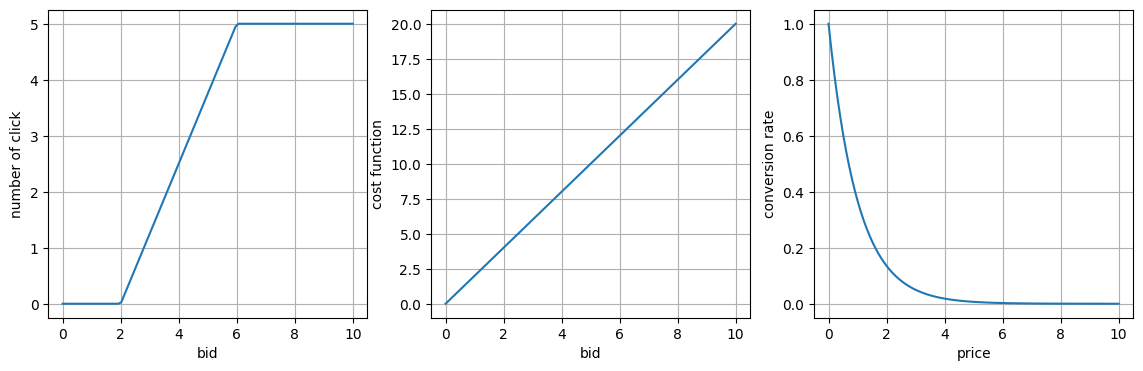

In [ ]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

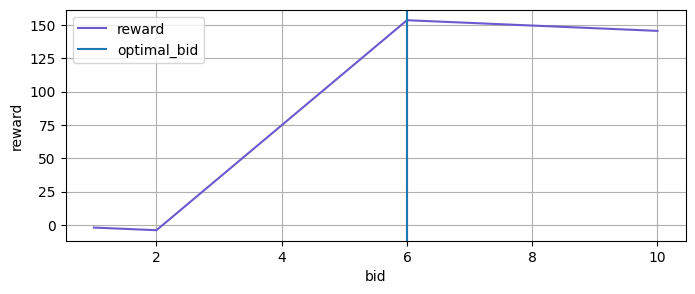

In [ ]:
#Fixed parameters
T = 80#100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the related conversion rate
PRICE = 1
conversion_rate = C1.conversion_rate_function(PRICE)

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)

rewards_on_arms = C1.n_daily_clicks_function(bids) * conversion_rate * margin - C1.cum_daily_costs_function(bids)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms
opt = rewards_on_arms[opt_arm]




n_experiments = 50#20




plt.figure(figsize=(8,3))
plt.plot(bids, rewards_on_arms, "slateblue")
plt.axvline(bids[opt_arm])
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(["reward","optimal_bid"])
plt.grid(True)

### UCB

In [ ]:
## UCB learner

gpucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

# gpucb_n_daily_clicks_hat = np.zeros(len(bids))
# gpucb_n_daily_clicks_std = np.zeros(len(bids))
# gpucb_cum_daily_costs_hat = np.zeros(len(bids))
# gpucb_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpucb_learner = Custom_GPUCB_Learner(bids,conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)
        
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(gpucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(gpucb_learner.cum_daily_costs_learner.means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpucb_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    # mean_prediction, std_prediction = gpucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpucb_cum_daily_costs_std += std_prediction  / n_experiments

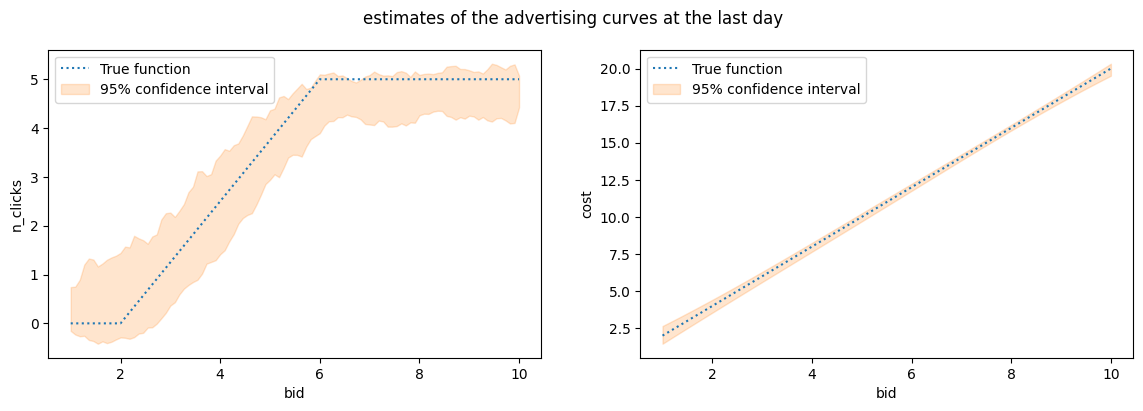

In [ ]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()


#OBS: Here, the CI is wrt the experimental results
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)



plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

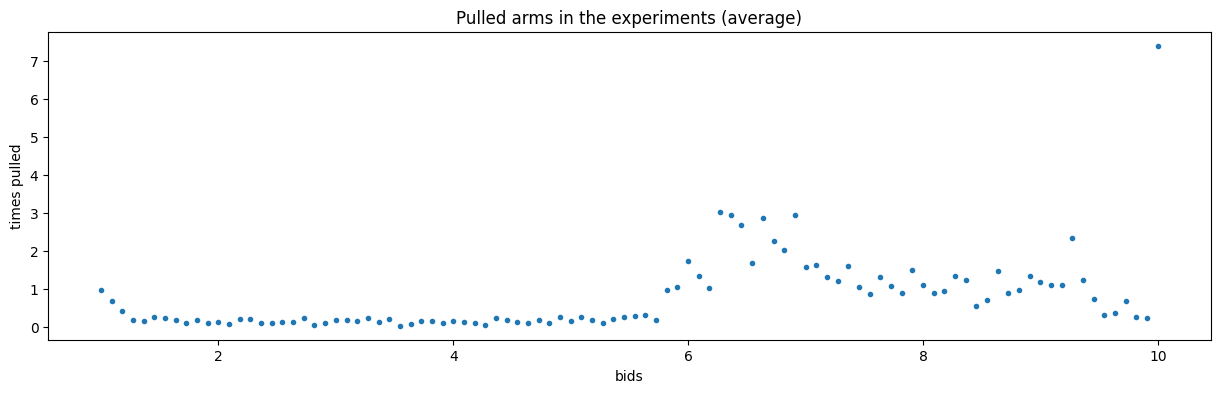

In [ ]:

zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))

ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

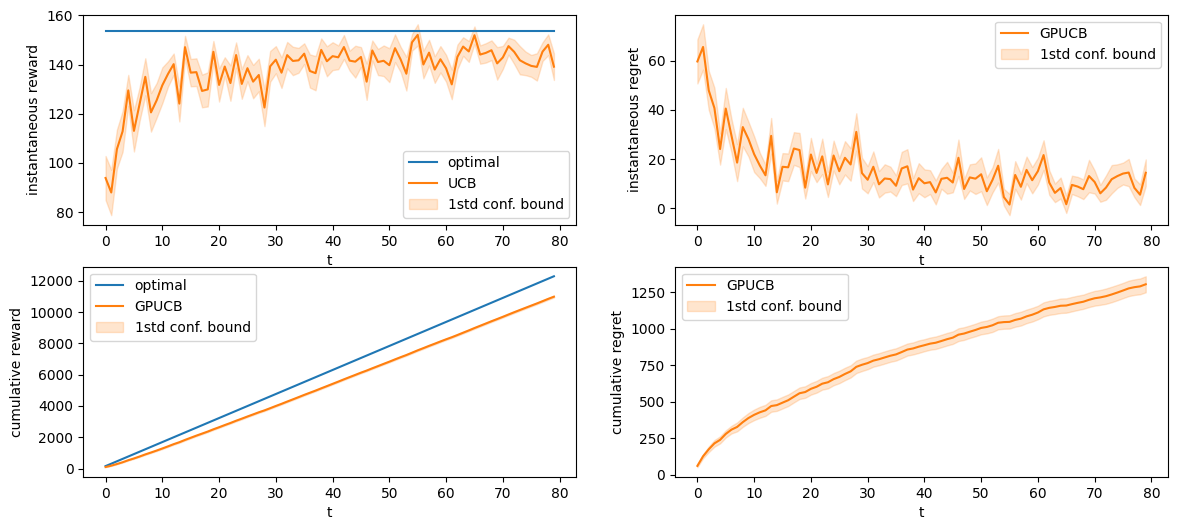

In [ ]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Thompson sampling

In [ ]:
## TS learner

gpts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

# gpts_n_daily_clicks_hat = np.zeros(len(bids))
# gpts_n_daily_clicks_std = np.zeros(len(bids))
# gpts_cum_daily_costs_hat = np.zeros(len(bids))
# gpts_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpts_learner = Custom_GPTS_Learner(bids, conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(gpts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(gpts_learner.cum_daily_costs_learner.means)
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpts_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpts_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpts_n_daily_clicks_std += std_prediction  / n_experiments
    # mean_prediction, std_prediction = gpts_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpts_cum_daily_costs_std += std_prediction  / n_experiments

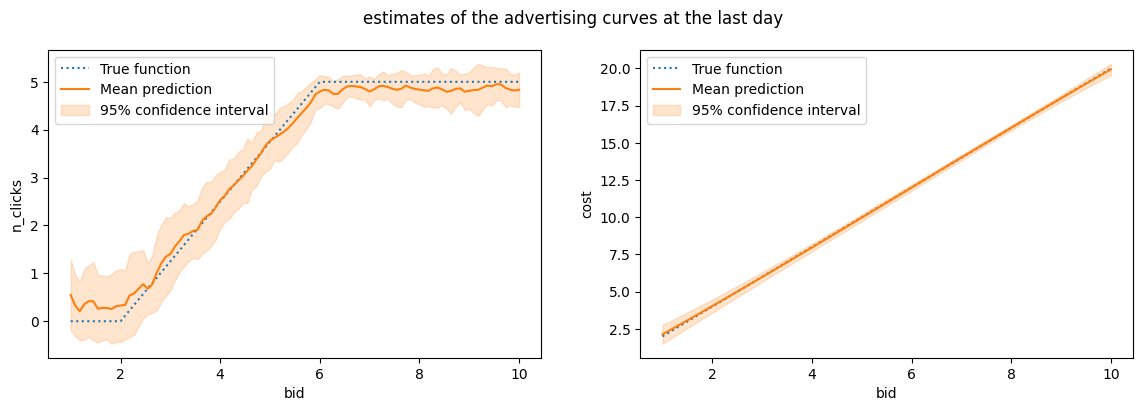

In [ ]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()
# plt.grid()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()
# plt.grid()


#OBS: Here, the CI is wrt the experimental results
ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

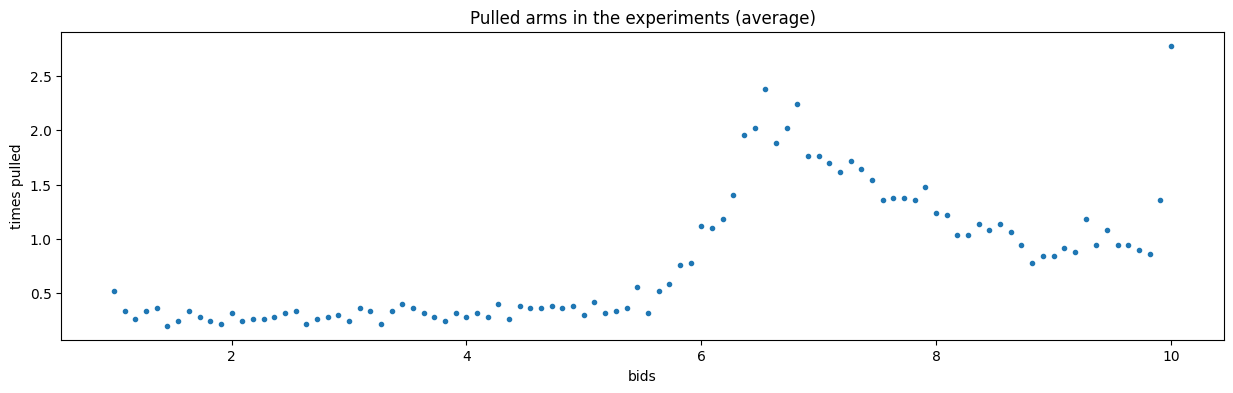

In [ ]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

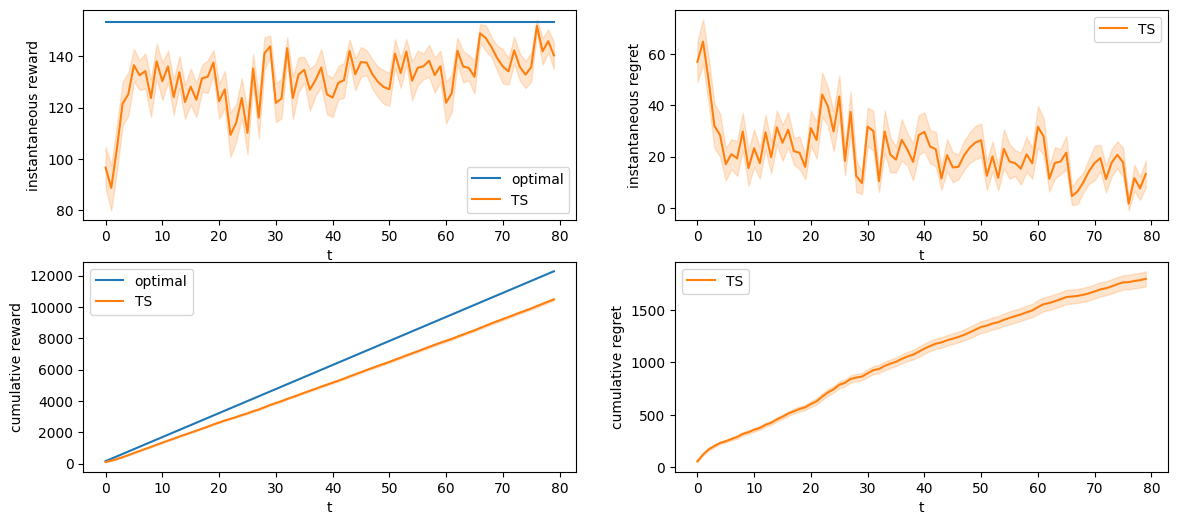

In [ ]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()

### Plots both methods

In [ ]:
ucb_std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

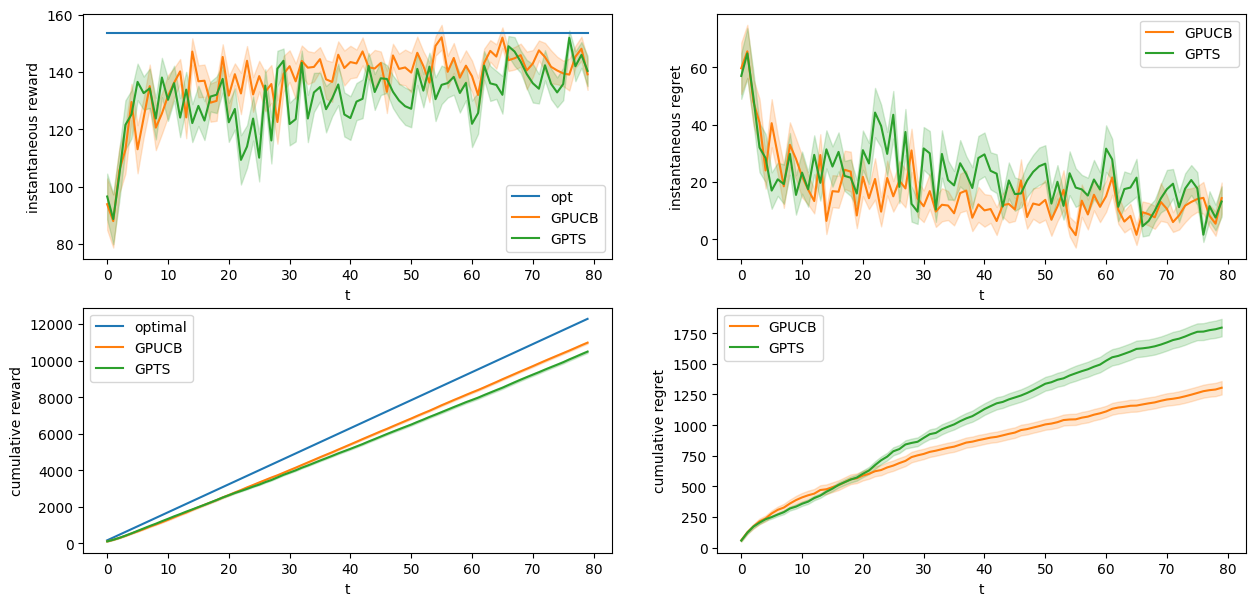

In [ ]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "GPTS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

# Step 3

**Framework**:  
just one class,  
alpha, n and c are unknown

TODO:
- change confidence interval in TS plot (?)
- change data using step 0
- decide if more plots are needed

### Environment

In [ ]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, userclass):
        self.userclass = userclass

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)
        self.pricing_environment = PricingEnvironment(prices, margin, userclass)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        reward = self.pricing_environment.round(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, reward

## Learners

the reward function in expectation is  
reward(bid,price) = n_daily_clicks(bid) * alpha(price) * margin - cum_daily_costs(bid)

OBS:  
classic bandits for pricing  
GP bandits for advertising

### UCB based

In [ ]:
class Custom_S3_UCB_Learner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.conversion_rate_learner = UCB1_Learner(n_arms_prices)


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        ub_convertion_rate = self.conversion_rate_learner.empirical_means[idx_price_arm] + self.conversion_rate_learner.confidence[idx_price_arm]

        upper_confidence = ub_clicks * ub_convertion_rate * self.margin - lb_costs
        idx_bid_arm = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])

        return (idx_bid_arm, idx_price_arm)


    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """

        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (reward + cum_daily_costs) / (n_daily_clicks * self.margin)
            self.conversion_rate_learner.update(pulled_arm_price, alpha)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 

### TS based

In [ ]:
class Custom_S3_TS_Learner(Learner):
    def __init__(self, arms_bids, arms_prices, margin):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin = margin

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)
        

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        idx_price_arm = np.argmax(sampled_conversion_rates)

        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        alpha = sampled_conversion_rates[idx_price_arm]
        idx_bid_arm = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        
        return (idx_bid_arm, idx_price_arm)
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            k = (reward + cum_daily_costs) / self.margin
            self.conversion_rate_learner.update(pulled_arm_price, k, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 


## Example

In [ ]:
F1 = 0
F2 = 0

def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max

    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

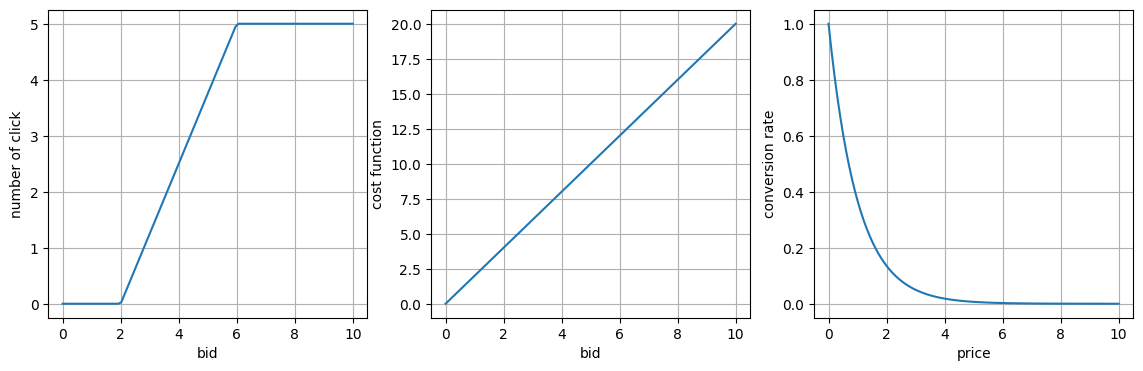

In [ ]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

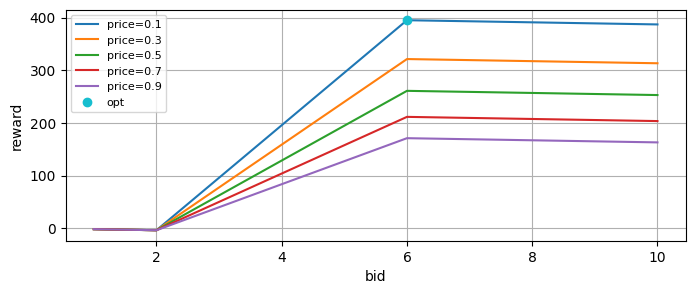

In [ ]:
#Fixed parameters
T = 100 #365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)
prices =  np.array([1,3,5,7,9]) / 10 #np.array([1,3,5,7,9])


opt_arm_price = np.argmax(C1.conversion_rate_function(prices)) #optimal value of conversion rate between the arms
opt_price = prices[opt_arm_price]

opt_conversion_rate = C1.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C1.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C1.cum_daily_costs_function(bids)) #optimal value of conversion rate between the arms
opt_bid = bids[opt_bid_arm]

opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)


opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs


n_experiments = 50


#Plot

plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C1.n_daily_clicks_function(bids) * C1.conversion_rate_function(price) * margin - C1.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ucb_learner = Custom_S3_UCB_Learner(bids, prices, margin)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)


    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(ucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(ucb_learner.cum_daily_costs_learner.means)
    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ucb_learner.rewards_per_arm])

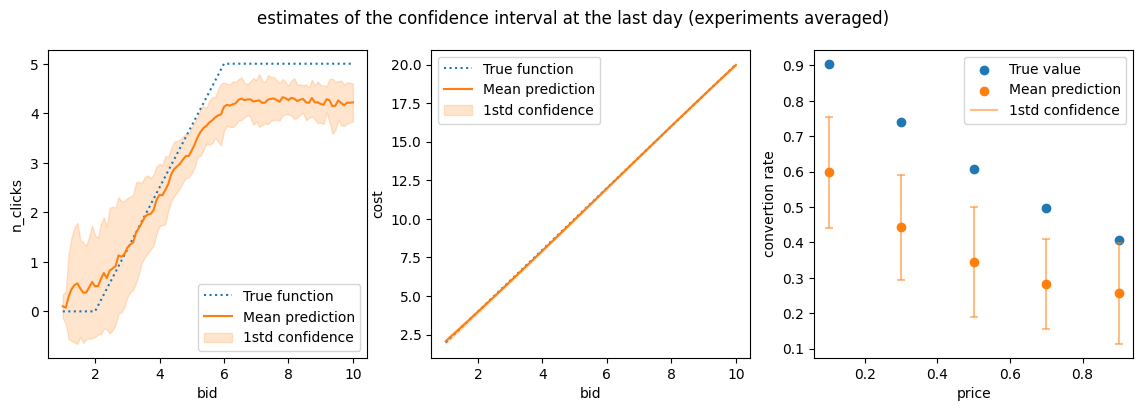

In [ ]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(prices, C1.conversion_rate_function(prices), label = "True value")
plt.scatter(prices, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

In [ ]:
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

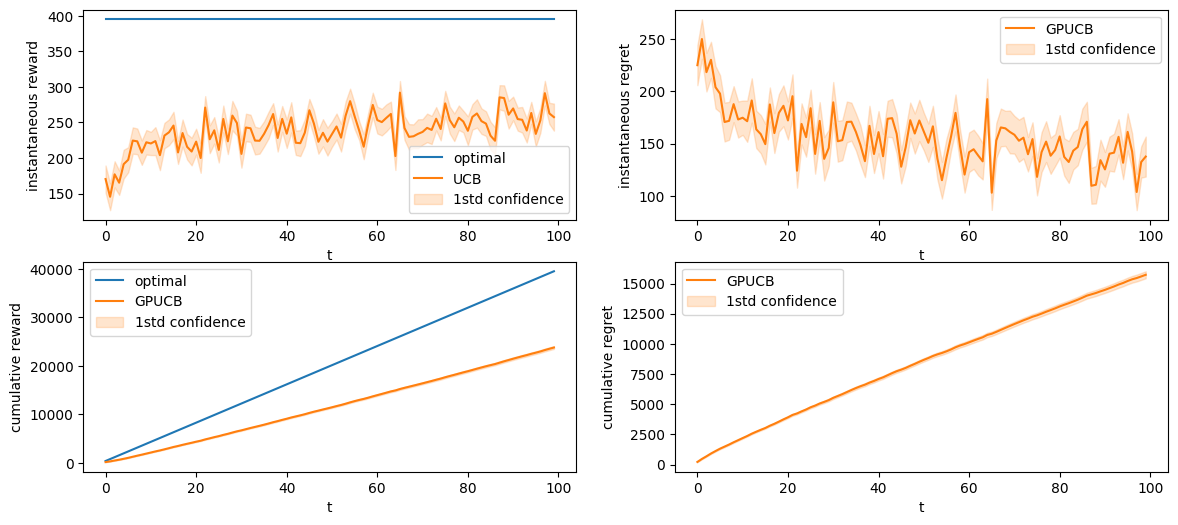

In [ ]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
## TS learner

ts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ts_learner = Custom_S3_TS_Learner(bids, prices, margin)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(ts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(ts_learner.cum_daily_costs_learner.means)
    ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1]))
    ts_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ts_learner.rewards_per_arm])

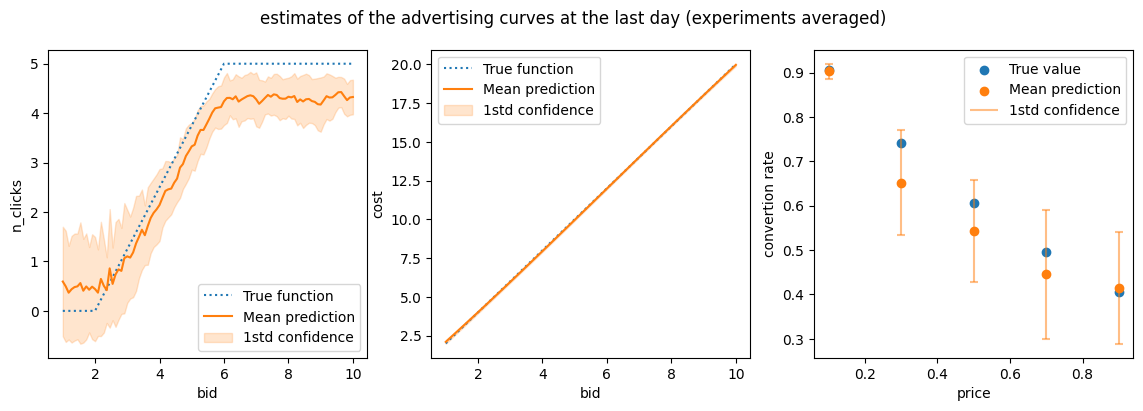

In [ ]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related

ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0)
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)


#ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
#ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(bids, C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(bids, C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(prices, C1.conversion_rate_function(prices), label = "True value")
plt.scatter(prices, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(prices, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(prices, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(prices, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

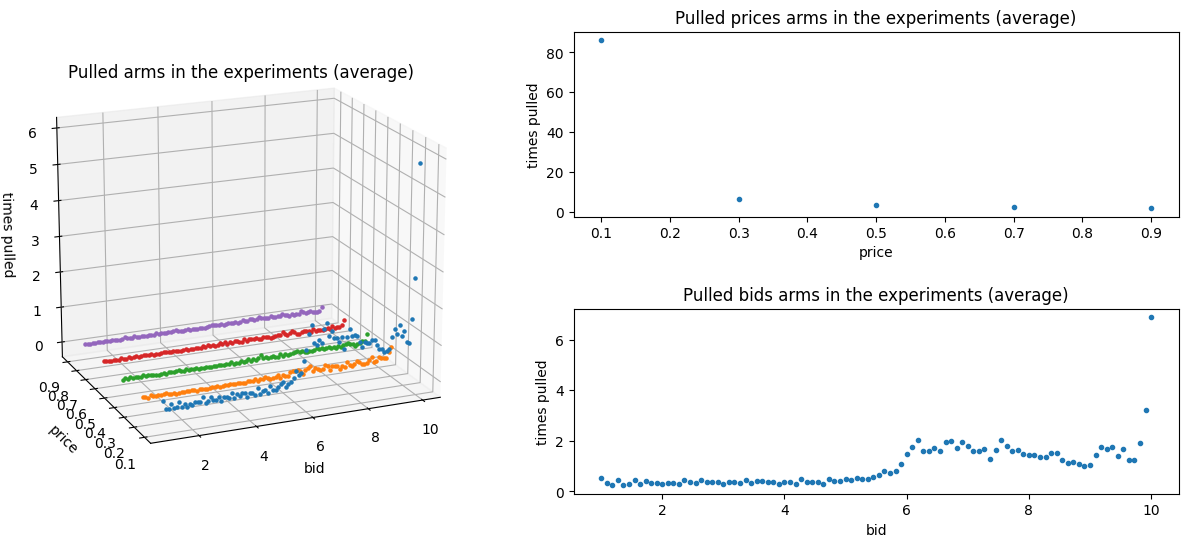

In [ ]:
#TODO: add something time related
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

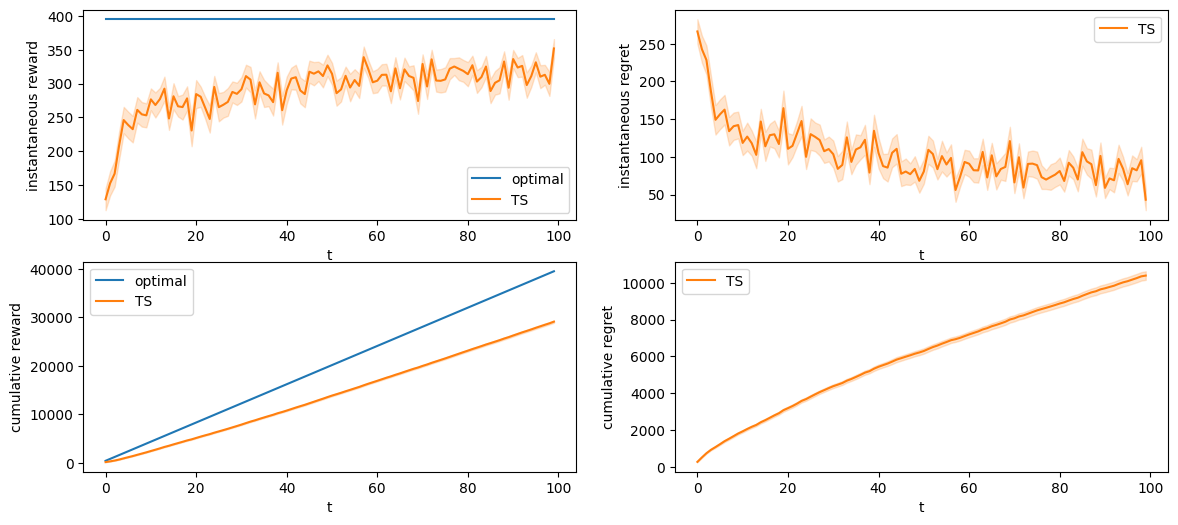

In [ ]:
std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

#Starting Plots
plt.figure(figsize = (14,6))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Instantaneous regret plot
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat - std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative regret plot
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Comparing UCB and TS

In [ ]:
## UCB
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

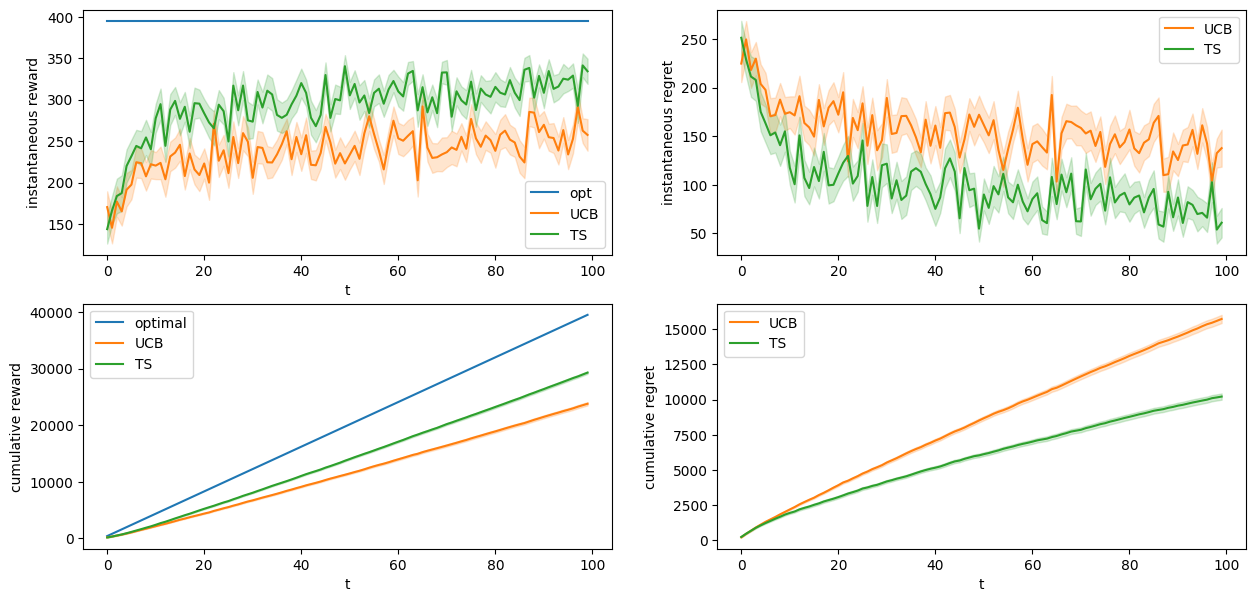

In [ ]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()